# Q-learning, Double Q-learning, Expected Sarsa and Double Expected Sarsa

<b>Gabriele Prato, McGill University</b>

In this notebook, we will be comparing Q-learning, Double Q-learning, Expected Sarsa and Double Expected Sarsa. Comparison will be made on the Maximisation Bias Example found in the class textbook [1]. Our goal will be to test which algorithm is affected the less by maximisation bias and compare performance on the environment.

Example 6.7 and Exercice 6.10 will be implemented.

## Libraries

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

## Example 6.7

The implemented Maximisation Bias Example is the same as the one described in the textbook [1].

In [5]:
class State:
    def __init__(self, ID, isTerminal):
        self.ID = ID
        self.transitions = []
        self.isTerminal = isTerminal
                  
    def addTransition(self, transition):
        self.transitions.append(transition)
                  
class Transition:
    def __init__(self, reward, nextState):
        self.reward = reward
        self.nextState = nextState
    
    def getReward(self):
        return self.reward
    
class RandomRewardTransition(Transition):
    def __init__(self, nextState):
        Transition.__init__(self, 0, nextState)
    
    def getReward(self):
        return np.random.normal(-0.1, 1.0, 1)[0]

In [6]:
TERMINAL = State(ID=2, isTerminal=True)
TERMINAL.addTransition(Transition(reward=0, nextState=None))

B = State(ID=1, isTerminal=False)
for i in range(10):
    B.addTransition(RandomRewardTransition(nextState=TERMINAL))

A = State(ID=0, isTerminal=False)
A.addTransition(Transition(reward=0, nextState=B))
A.addTransition(Transition(reward=0, nextState=TERMINAL))

We will now implement Q-learning and Double Q-learning. Expected Sarsa and Double Expected Sarsa will be implemented in Exercice 6.10. The class ControlAlgorithm is the basis for all four algorithms. It has all the code used to run the core algorithm multiple times, average the statistics and view the learned policy. The classes for the four algorithms will only contain the core algorithm.

In [7]:
class ControlAlgorithm:
    def __init__(self, state, ALPHA, DISCOUNT, EPSILON):
        self.Q = [[0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
        self.state = state
        self.startingState = state
        self.ALPHA = ALPHA
        self.DISCOUNT = DISCOUNT
        self.EPSILON = EPSILON
     
    def averageMRunsOfNEpisodes(self, M, N):
        leftActionCounterPerEpisode = np.zeros(N)
        
        for i in range(M):
            self.resetQ()
            
            for j in range(N):
                actionLog = self.generateEpisode()
                if actionLog[0] == 0:
                    leftActionCounterPerEpisode[j] += 1
        
        return leftActionCounterPerEpisode / float(M)
    
    def resetQ(self):
        self.Q = [[0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
    
    def chooseAction(self):
        if np.random.rand(1)[0] <= self.EPSILON:
            return np.random.randint(len(self.state.transitions), size=1)[0]
        else:
            return self.getMaxValuedActionOfState(self.Q, self.state)
    
    def getMaxValuedActionOfState(self, Q, state):
        # If multiple actions have the same max value, we need to choose one of them randomly
        possibleActions = []
        maxValue = np.NINF
        for i in range(len(state.transitions)):
            if Q[state.ID][i] == maxValue:
                possibleActions.append(i)
            elif Q[state.ID][i] > maxValue:
                possibleActions = [i]
                maxValue = Q[state.ID][i]

        return random.choice(possibleActions)

In [8]:
class Qlearning(ControlAlgorithm):
    def __init__(self, state, ALPHA, DISCOUNT, EPSILON):
        ControlAlgorithm.__init__(self, state, ALPHA, DISCOUNT, EPSILON)
        
    def generateEpisode(self):
        self.state = self.startingState
        reward = 0
        actionLog = []

        while not self.state == TERMINAL:
            action = self.chooseAction()
            actionLog.append(action)
            reward = self.state.transitions[action].getReward()
            nextState = self.state.transitions[action].nextState
        
            self.Q[self.state.ID][action] += self.ALPHA * (reward + self.DISCOUNT *
                self.Q[nextState.ID][self.getMaxValuedActionOfState(self.Q, nextState)] - 
                self.Q[self.state.ID][action])
        
            self.state = nextState
        
        return actionLog

In [9]:
class DoubleQlearning(ControlAlgorithm):
    def __init__(self, state, ALPHA, DISCOUNT, EPSILON):
        ControlAlgorithm.__init__(self, state, ALPHA, DISCOUNT, EPSILON)
        self.Q2 = [[0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
    
    def resetQ(self):
        self.Q = [[0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
        self.Q2 = [[0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
        
    def chooseAction(self):
        if np.random.rand(1)[0] <= self.EPSILON:
            return np.random.randint(len(self.state.transitions), size=1)[0]
        else:
            return self.getMaxValuedActionOfStateUsingBothQs(self.state)
        
    def generateEpisode(self):
        self.state = self.startingState
        reward = 0
        actionLog = []

        while not self.state == TERMINAL:
            action = self.chooseAction()
            actionLog.append(action)
            reward = self.state.transitions[action].getReward()
            nextState = self.state.transitions[action].nextState
        
            if np.random.randint(2, size=1)[0] == 0:
                self.Q[self.state.ID][action] += self.ALPHA * (reward + self.DISCOUNT * 
                    self.Q2[nextState.ID][self.getMaxValuedActionOfState(self.Q, nextState)] - 
                    self.Q[self.state.ID][action])
            else:
                self.Q2[self.state.ID][action] += self.ALPHA * (reward + self.DISCOUNT * 
                    self.Q[nextState.ID][self.getMaxValuedActionOfState(self.Q2, nextState)] - 
                    self.Q2[self.state.ID][action])
        
            self.state = nextState
        
        return actionLog
    
    def getMaxValuedActionOfStateUsingBothQs(self, state):
        # If multiple actions have the same max value, we need to choose one of them randomly
        possibleActions = []
        maxValue = np.NINF
        for i in range(len(state.transitions)):
            if self.Q[state.ID][i] + self.Q2[state.ID][i] == maxValue:
                possibleActions.append(i)
            elif self.Q[state.ID][i] + self.Q2[state.ID][i] > maxValue:
                possibleActions = [i]
                maxValue = self.Q[state.ID][i] + self.Q2[state.ID][i]

        return random.choice(possibleActions)

ε, α and γ will be the same as in the book [1] for this example and throughout the notebook.

In [10]:
ALPHA = 0.1
DISCOUNT = 1.0
EPSILON = 0.1

Let's see how these algorithms perform on the MDP:

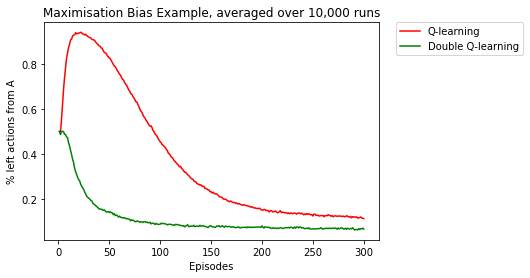

In [11]:
ql = Qlearning(A, ALPHA, DISCOUNT, EPSILON)
leftActionPourcentagePerEpisodeQl = ql.averageMRunsOfNEpisodes(10000, 300)

dql = DoubleQlearning(A, ALPHA, DISCOUNT, EPSILON)
leftActionPourcentagePerEpisodeDQl = dql.averageMRunsOfNEpisodes(10000, 300)

plt.plot(np.arange(1, 301), leftActionPourcentagePerEpisodeQl, 'r', label="Q-learning")
plt.plot(np.arange(1, 301), leftActionPourcentagePerEpisodeDQl, 'g', label="Double Q-learning")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Episodes')
plt.ylabel('% left actions from A')
plt.title('Maximisation Bias Example, averaged over 10,000 runs')
plt.show()

As we can see, the results are very similar to the ones shown in the textbook [1]. Double Q-learning is unaffected by maximisation bias and learns to take the right action very early. Q-learning is affected by maximisation bias and learns to take the left action and over time learns to take the right action.

## Exercice 6.10

Here is the question found in the exercice [1]:<br/>
<i>What are the update equations for Double Expected Sarsa with an ε-greedy target policy?</i>

First let us implement Expected Sarsa:

In [18]:
class ExpectedSarsa(ControlAlgorithm):
    def __init__(self, state, ALPHA, DISCOUNT, EPSILON):
        ControlAlgorithm.__init__(self, state, ALPHA, DISCOUNT, EPSILON)
        
    def generateEpisode(self):
        self.state = self.startingState
        reward = 0
        actionLog = []

        while not self.state == TERMINAL:
            action = self.chooseAction()
            actionLog.append(action)
            reward = self.state.transitions[action].getReward()
            nextState = self.state.transitions[action].nextState
        
            self.Q[self.state.ID][action] += self.ALPHA * (reward + self.DISCOUNT *
                self.getExpectedStateActionValue(self.Q, nextState) - self.Q[self.state.ID][action])
        
            self.state = nextState
        
        return actionLog
    
    def getExpectedStateActionValue(self, Q, state):
        maxValue = max(Q[state.ID])
            
        # If multiple actions have the same max value
        maxValueActions = set()
        for i in range(len(state.transitions)):
            if Q[state.ID][i] == maxValue:
                maxValueActions.add(i)
        
        value = 0    
        for i in range(len(state.transitions)):
            probability = self.EPSILON / len(state.transitions)
            if i in maxValueActions:
                probability += (1 - self.EPSILON) / len(maxValueActions)
            
            value += probability * Q[state.ID][i]
        
        return value

Now, here is the complete pseudocode for the Double Expected Sarsa algorithm:

![pseudoCode](doubleExpectedSarsaEquation.png)

And the code in python:

In [20]:
class DoubleExpectedSarsa(ExpectedSarsa):
    def __init__(self, state, ALPHA, DISCOUNT, EPSILON):
        ExpectedSarsa.__init__(self, state, ALPHA, DISCOUNT, EPSILON)
        self.Q2 = [[0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
        
    def resetQ(self):
        self.Q = [[0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
        self.Q2 = [[0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
    
    def generateEpisode(self):
        self.state = self.startingState
        reward = 0
        actionLog = []

        while not self.state == TERMINAL:
            action = self.chooseAction()
            actionLog.append(action)
            reward = self.state.transitions[action].getReward()
            nextState = self.state.transitions[action].nextState
            
            if np.random.randint(2, size=1)[0] == 0:
                self.Q[self.state.ID][action] += self.ALPHA * (reward + self.DISCOUNT * 
                    self.getExpectedStateActionValue(self.Q2, nextState) - self.Q[self.state.ID][action])
            else:
                self.Q2[self.state.ID][action] += self.ALPHA * (reward + self.DISCOUNT * 
                    self.getExpectedStateActionValue(self.Q, nextState) - self.Q2[self.state.ID][action])
        
            self.state = nextState
        
        return actionLog

Let's see how they compare to our previous results:

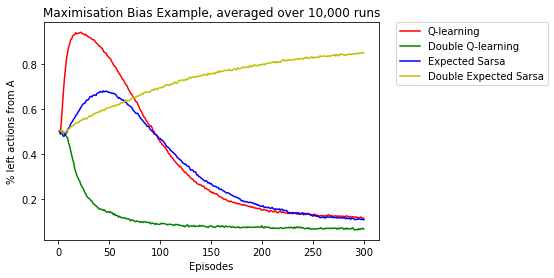

In [21]:
expSarsa = ExpectedSarsa(A, ALPHA, DISCOUNT, EPSILON)
leftActionPourcentagePerEpisodeExpSarsa = expSarsa.averageMRunsOfNEpisodes(10000, 300)

dexpSarsa = DoubleExpectedSarsa(A, ALPHA, DISCOUNT, EPSILON)
leftActionPourcentagePerEpisodeDExpSarsa = dexpSarsa.averageMRunsOfNEpisodes(1000, 300)

plt.plot(np.arange(1, 301), leftActionPourcentagePerEpisodeQl, 'r', label="Q-learning")
plt.plot(np.arange(1, 301), leftActionPourcentagePerEpisodeDQl, 'g', label="Double Q-learning")
plt.plot(np.arange(1, 301), leftActionPourcentagePerEpisodeExpSarsa, 'b', label="Expected Sarsa")
plt.plot(np.arange(1, 301), leftActionPourcentagePerEpisodeDExpSarsa, 'y', label="Double Expected Sarsa")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Episodes')
plt.ylabel('% left actions from A')
plt.title('Maximisation Bias Example, averaged over 10,000 runs')
plt.show()

Expected Sarsa is affected by maximisation bias, although less than Q-learning. It also learns to take the right action more slowly than Q-learning.

Surprisingly, Double Expected Sarsa never learns to take the right action. It actually takes the left action more and more often. Having two estimes Q and Q2 does not help the algorithm negate the maximisation bias. 

## Conclusion

We've implemented and compared the Q-learning, Double Q-learning, Expected Sarsa and Double Expected Sarsa algorithms on the MDP environment found in Example 6.7 of the class textbook [1].

The only algorithm that was unaffected by maximisation bias was Double Q-learning. Q-learning and Expected Sarsa were affected early on in the episodes, Q-learning being affected the most. Double Expected Sarsa performed worse and worse, learning to take the left action more and more often as episodes passed.

It would be interesting to try more algorithms on this problem, to see how they are affected by maximisation bias.

It would also be interesting to test Double Expected Sarsa on other environments, to see which advantage it has over Expected Sarsa.

## References

[1] <a href="https://webdocs.cs.ualberta.ca/~sutton/book/the-book-2nd.html">Richard S. Sutton and Andrew G. Barto, "Reinforcement learning: An introduction", Second Edition, MIT Press</a>, in preparation<br />
Example 6.7 and Exercice 6.10 can be found on page 143-145